### Imports

In [1]:
import sys
import numpy as np
import math
from IPython.display import display, Math, Latex, Markdown, HTML

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm 
import pyvista as pv
from pyvista import examples
from pyvista import set_plot_theme
set_plot_theme('document')

## Point To Point

### Data Plotting

In [2]:
def bigPlot(P, Q, pSize, qSize):    
    sourceCloud = pv.PolyData(Q.T)
    destinationCloud = pv.PolyData(P.T)
    plotter = pv.Plotter()
    sargs = dict(height=0.25, vertical=True, position_x=0.05, position_y=0.05)
    plotter.add_text("Point Clouds", font_size=10)
    plotter.add_mesh(sourceCloud, 
                     color='lightblue',
                     point_size = pSize,
                     render_points_as_spheres = True,
                     show_scalar_bar=False,
                     label = 'True Data')

    plotter.add_mesh(destinationCloud, 
                     color='orange',
                     point_size = qSize,
                     render_points_as_spheres = True,
                     show_scalar_bar=False,
                     label='Moved Data')
    plotter.show_grid()
    plotter.add_legend(size = (0.1, 0.1))
    plotter.show()

In [3]:
'''Plot the true and moved data using Matplotlib'''
def plotData(data1, data2, label1, label2, markersize1 = 20, markersize2 = 20):
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.set_title("Point Clouds")
    if data1 is not None:
        xdata1 = data1[0, :]
        ydata1 = data1[1, :]
        zdata1 = data1[2, :]
        ax.scatter3D(xdata1, ydata1, zdata1, s= markersize1, label = label1);
    
    if data2 is not None:
        xdata2 = data2[0, :]
        ydata2 = data2[1, :]
        zdata2 = data2[2, :]
        ax.scatter3D(xdata2, ydata2, zdata2, s= markersize2, label=label2);

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()

def plotValues(values, label):
    plt.figure(figsize = (10, 4))
    plt.title("Error")
    plt.plot(values, label=label)
    plt.legend()
    plt.grid(True)
    plt.show()

### Data Generation

In [4]:
'''Samples in a cube'''
def generateData(numPoints, angle, shift):
    
    aboutZ = np.array([[math.cos(angle[2]), -math.sin(angle[2]), 0], 
                      [math.sin(angle[2]), math.cos(angle[2]), 0],
                      [0, 0, 1]])
    aboutY = np.array([[math.cos(angle[1]), 0, -math.sin(angle[1])],
                      [0, 1, 0] ,
                      [math.sin(angle[1]), 0, math.cos(angle[1])]])
    aboutX = np.array([[1, 0, 0],
                      [0, math.cos(angle[0]), -math.sin(angle[0])],
                      [0, math.sin(angle[0]), math.cos(angle[0])]])
      
    T = shift
    R = aboutZ.dot(aboutY.dot(aboutX))
    sourceData = np.random.rand(3, numPoints)
    movedData = R.dot(sourceData) + shift
    return sourceData, movedData

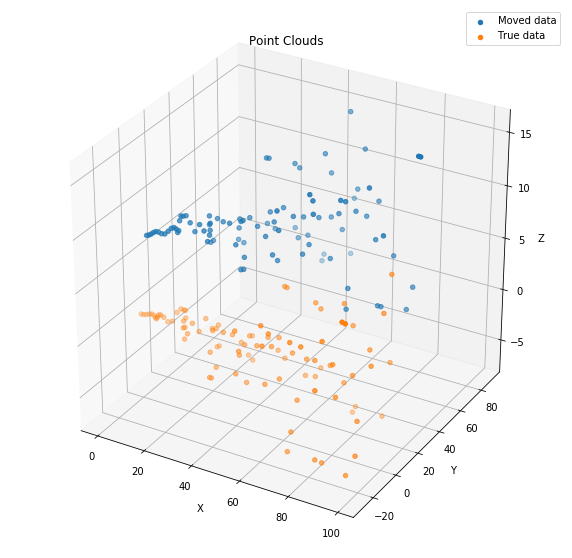

In [5]:
'''Generate data using the sin and cosine functions'''
def generateSpiral(numPoints, angle, shift):
    
    aboutZ = np.array([[math.cos(angle[2]), -math.sin(angle[2]), 0], 
                      [math.sin(angle[2]), math.cos(angle[2]), 0],
                      [0, 0, 1]])
    aboutY = np.array([[math.cos(angle[1]), 0, -math.sin(angle[1])],
                      [0, 1, 0] ,
                      [math.sin(angle[1]), 0, math.cos(angle[1])]])
    aboutX = np.array([[1, 0, 0],
                      [0, math.cos(angle[0]), -math.sin(angle[0])],
                      [0, math.sin(angle[0]), math.cos(angle[0])]])
    aboutY = np.identity(3)
    aboutX = np.identity(3)
      
    T = shift
    R = aboutZ.dot(aboutY.dot(aboutX))
    sourceData = np.zeros((3, numPoints))
    sourceData[0, :] = range(0, numPoints)
    sourceData[1, :] = 0.3 * sourceData[0, :] * np.sin(0.5 * sourceData[0, :]) 
    sourceData[2, :] = 0.3 * sourceData[1, :] * np.sin(0.5 * sourceData[1, :]) 
    
    movedData = R.dot(sourceData) + shift
    return sourceData, movedData

'''Assign data to point clouds P and Q''' 
angle = [0, 0, math.pi/4]
shift = np.array([[0], [6], [7]])
Q, P = generateSpiral(100, angle, shift)

plotData(P, Q, "Moved data", "True data")
plt.show()

### Identifying Corresponding Points 

In [6]:
'''For each point in the  moved data get closest points in the source data'''
def slowCorrespondences(P, Q):
    pSize = P.shape[1]
    qSize = Q.shape[1]
    correspondences = []
    for i in range(pSize):
        pPoint = P[:, i]
        minDist = sys.maxsize
        chosenIndex = -1
        for j in range(qSize):
            qPoint = Q[:, j]
            dist = np.linalg.norm(qPoint - pPoint)
            if dist < minDist:
                minDist = dist
                chosenIndex = j
        correspondences.append((i, chosenIndex))
    return correspondences


from sklearn.neighbors import KDTree

def getCorrespondences(P, Q):
    tree = KDTree(Q.T)
    dist, ind = tree.query(P.T)
    correspondences = [(i, ind[i][0]) for i in range(P.T.shape[0])]
    return correspondences

'''Connect the obtained corresponding points using grey lines'''
def drawCorrespondences(P, Q, correspondences):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        z = [P[2, i], Q[2, j]]
        if not label_added:
            plt.plot(x, y, zs=z, color='grey', label='correpondences')
            label_added = True
        else:
            plt.plot(x, y, zs=z, color='grey')
    plt.legend()

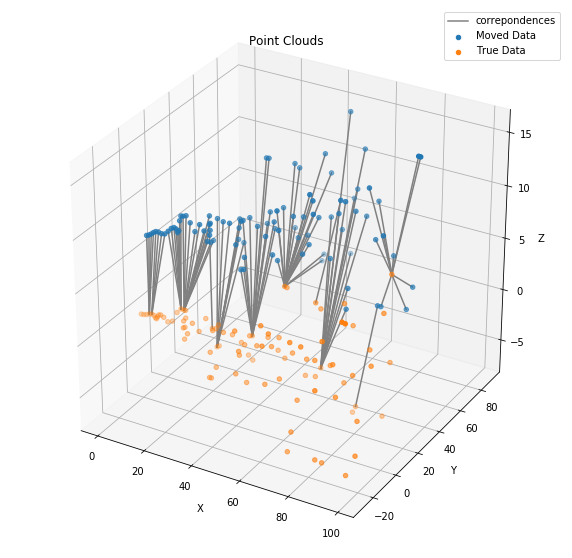

In [7]:
correspondences = getCorrespondences(P, Q)
plotData(P, Q, 'Moved Data', 'True Data')
drawCorrespondences(P, Q, correspondences)
plt.show()

In [8]:
def RotationMatrix(phi, theta, shi):
    return Matrix([
    [cos(shi) * cos(theta), cos(shi) * sin(theta) * sin(phi) - sin(shi) * cos(phi), cos(shi) * sin(theta) * cos(phi) + sin(shi) * sin(phi)], 
    [sin(shi) * cos(theta), sin(shi) * sin(theta) * sin(phi) + cos(shi) * cos(phi), sin(shi) * sin(theta) * cos(phi) - cos(shi) * sin(phi)],
    [-sin(theta), cos(theta) * sin(phi), cos(theta) * cos(phi)]])

def R(phi, theta, shi): 
    return np.array([
    [math.cos(shi) * math.cos(theta), math.cos(shi) * math.sin(theta) * math.sin(phi) - math.sin(shi) * math.cos(phi), math.cos(shi) * math.sin(theta) * math.cos(phi) + math.sin(shi) * math.sin(phi)], 
    [math.sin(shi) * math.cos(theta), math.sin(shi) * math.sin(theta) * math.sin(phi) + math.cos(shi) * math.cos(phi), math.sin(shi) * math.sin(theta) * math.cos(phi) - math.cos(shi) * math.sin(phi)],
    [-math.sin(theta), math.cos(theta) * math.sin(phi), math.cos(theta) * math.cos(phi)]])

In [9]:
from sympy import init_printing, symbols, Matrix, cos, sin, diff
from IPython.display import display, Math, Latex, Markdown, HTML
from sympy import lambdify

init_printing(use_unicode = True)


x, y, z, phi, theta, shi, p_x, p_y, p_z= symbols('x, y, z, \\phi, \\theta, \\psi, p_x, p_y, p_z')


t = Matrix([[x], [y], [z]])
X = Matrix([x, y, z, phi, theta, shi])
p = Matrix([[p_x], [p_y], [p_z]])

_moved_point = RotationMatrix(phi, theta, shi) * p + t

_jacobian = diff(_moved_point, X).reshape(6, 3).transpose() 
display(Latex('Moved Point'), _moved_point)
display(Latex('Jacobian'), _jacobian)

<IPython.core.display.Latex object>

⎡pₓ⋅cos(\psi)⋅cos(\theta) + p_y⋅(sin(\phi)⋅sin(\theta)⋅cos(\psi) - sin(\psi)⋅c
⎢                                                                             
⎢pₓ⋅sin(\psi)⋅cos(\theta) + p_y⋅(sin(\phi)⋅sin(\psi)⋅sin(\theta) + cos(\phi)⋅c
⎢                                                                             
⎣                                       -pₓ⋅sin(\theta) + p_y⋅sin(\phi)⋅cos(\t

os(\phi)) + p_z⋅(sin(\phi)⋅sin(\psi) + sin(\theta)⋅cos(\phi)⋅cos(\psi)) + x ⎤
                                                                            ⎥
os(\psi)) + p_z⋅(-sin(\phi)⋅cos(\psi) + sin(\psi)⋅sin(\theta)⋅cos(\phi)) + y⎥
                                                                            ⎥
heta) + p_z⋅cos(\phi)⋅cos(\theta) + z                                       ⎦

<IPython.core.display.Latex object>

⎡1  0  0  p_y⋅(sin(\phi)⋅sin(\psi) + sin(\theta)⋅cos(\phi)⋅cos(\psi)) + p_z⋅(-
⎢                                                                             
⎢0  1  0  p_y⋅(-sin(\phi)⋅cos(\psi) + sin(\psi)⋅sin(\theta)⋅cos(\phi)) + p_z⋅(
⎢                                                                             
⎣0  0  1                                     p_y⋅cos(\phi)⋅cos(\theta) - p_z⋅s

sin(\phi)⋅sin(\theta)⋅cos(\psi) + sin(\psi)⋅cos(\phi))   -pₓ⋅sin(\theta)⋅cos(\
                                                                              
-sin(\phi)⋅sin(\psi)⋅sin(\theta) - cos(\phi)⋅cos(\psi))  -pₓ⋅sin(\psi)⋅sin(\th
                                                                              
in(\phi)⋅cos(\theta)                                                    -pₓ⋅co

psi) + p_y⋅sin(\phi)⋅cos(\psi)⋅cos(\theta) + p_z⋅cos(\phi)⋅cos(\psi)⋅cos(\thet
                                                                              
eta) + p_y⋅sin(\phi)⋅sin(\psi)⋅cos(\theta) + p_z⋅s

In [10]:
def computeNormals(points, step=1):
    normals = [np.array([0, 0, 0])]
    normals_at_points = []
    for i in range(step, points.shape[1] - step):
        prev_point = points[:, i - step]
        next_point = points[:, i + step]
        curr_point = points[:, i]
        a_bar = prev_point - curr_point
        b_bar = next_point - curr_point
        normal = np.cross(a_bar, b_bar)
        normal = normal / np.linalg.norm(normal)
        normals.append(normal)  
        normals_at_points.append(normal + curr_point)
    normals.append(np.array([0, 0, 0]))
    return np.array(normals), normals_at_points

In [11]:
n_x, n_y, n_z = symbols(' n_x, n_y, n_z')
n = Matrix([[n_x],[n_y], [n_z]])

_error_normal = n.dot(RotationMatrix(phi, theta, shi) * p + t)

display(Latex("Moved Point With Normals: "),_error_normal)

_jacobian_normal = diff(_error_normal, X).reshape(6, 1).transpose()

display(Latex("Point to plane Jacobian: "), _jacobian_normal)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

[nₓ  n_y  n_z  nₓ⋅(p_y⋅(sin(\phi)⋅sin(\psi) + sin(\theta)⋅cos(\phi)⋅cos(\psi))
 + p_z⋅(-sin(\phi)⋅sin(\theta)⋅cos(\psi) + sin(\psi)⋅cos(\phi))) + n_y⋅(p_y⋅(-
sin(\phi)⋅cos(\psi) + sin(\psi)⋅sin(\theta)⋅cos(\phi)) + p_z⋅(-sin(\phi)⋅sin(\
psi)⋅sin(\theta) - cos(\phi)⋅cos(\psi))) + n_z⋅(p_y⋅cos(\phi)⋅cos(\theta) - p_
z⋅sin(\phi)⋅cos(\theta))  nₓ⋅(-pₓ⋅sin(\theta)⋅cos(\psi) + p_y⋅sin(\phi)⋅cos(\p
si)⋅cos(\theta) + p_z⋅cos(\phi)⋅cos(\psi)⋅cos(\theta)) + n_y⋅(-pₓ⋅sin(\psi)⋅si
n(\theta) + p_y⋅sin(\phi)⋅sin(\psi)⋅cos(\theta) + p_z⋅sin(\psi)⋅cos(\phi)⋅cos(
\theta)) + n_z⋅(-pₓ⋅cos(\theta) - p_y⋅sin(\phi)⋅sin(\theta) - p_z⋅sin(\theta)⋅
cos(\phi))  nₓ⋅(-pₓ⋅sin(\psi)⋅cos(\theta) + p_y⋅(-sin(\phi)⋅sin(\psi)⋅sin(\the
ta) - cos(\phi)⋅cos(\psi)) + p_z⋅(sin(\phi)⋅cos(\psi) - sin(\psi)⋅sin(\theta)⋅
cos(\phi))) + n_y⋅(pₓ⋅cos(\psi)⋅cos(\theta) + p_y⋅(sin(\phi)⋅sin(\theta)⋅cos(\
psi) - sin(\psi)⋅cos(\phi)) + p_z⋅(sin(\phi)⋅sin(\psi) + sin(\theta)⋅cos(\phi)
⋅cos(\psi)))]

In [12]:
s = (phi, theta, shi, p_x, p_y, p_z, n_x, n_y, n_z)
lambdanormaljacobian = lambdify(s, _jacobian_normal, modules='numpy')

def jacobianNormal(x, p, normal)-> np.array:
    J = lambdanormaljacobian(*x.reshape(-1)[3:], *list(p), *normal)
    return np.array(J)

In [13]:
s = (x, y, z, phi, theta, shi, p_x, p_y, p_z)
calcuatemovedpoint = lambdify(s, _moved_point, modules='numpy')

def calculateError(x, pPoint, qPoint) -> np.array:
    x = x.reshape(-1)
    pNew = calcuatemovedpoint(*x, *pPoint)
    return pNew - qPoint.reshape(3, 1)   

In [14]:
def prepareNormals(x, P, Q, correspondences, normals):
    H = np.zeros((6, 6))
    g = np.zeros((6, 1))
    chi = 0
    for (i, j), normal in zip(correspondences, normals):
        
        pPoint, qPoint = P[:, [i]], Q[:, [j]]
        
        e = normal.dot(calculateError(x.reshape(-1), pPoint.reshape(-1), qPoint.reshape(-1)))
        
        J = jacobianNormal(x.reshape(-1), pPoint.reshape(-1), normal.reshape(-1))
        H += J.T.dot(J)
        g += (J.T.reshape(6, 1)).dot(e.reshape(1, 1))
        chi += e.T * e
    return H, g, chi

In [15]:
def ICP(P, Q, normals, iterations = 20):
    x = np.zeros((6, 1))
    chiValues = []
    xValues = [x.copy()] 
    Pvalues = [P.copy()]
    Platest = P.copy()
    correspValues = []
    for it in tqdm( range(iterations), desc ="Iteration"):
        rot = R(*x[3:])
        t = x[0:3]
        correspondences = getCorrespondences(Platest, Q)
        correspValues.append(correspondences)
        H, g, chi = prepareNormals(x, P, Q, correspondences, normals)
        dx = np.linalg.lstsq(H, -g, rcond=None)[0]
        x += dx
        
        chiValues.append(chi.item(0)) 
        xValues.append(x.copy())
        
        rot = R(*x[3:])
        t = x[0:3]
        Platest = rot.dot(P.copy()) + t
        Pvalues.append(Platest)
    correspValues.append(correspValues[-1])
    return Pvalues, chiValues, correspValues

Iteration: 100%|██████████| 20/20 [00:00<00:00, 38.19it/s]


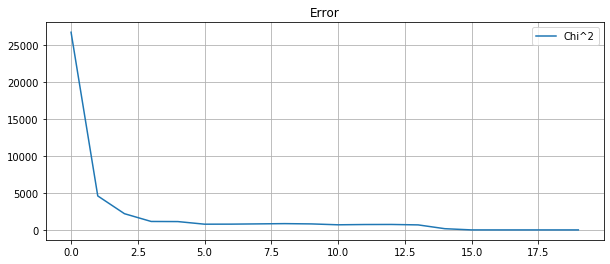

CPU times: user 557 ms, sys: 21.2 ms, total: 578 ms
Wall time: 723 ms


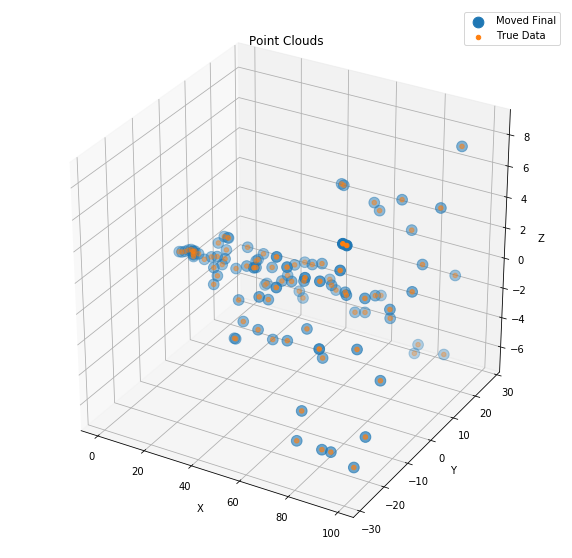

In [16]:
%%time
normals, normals_to_draw = computeNormals(Q)
P_values, chi_values, corresp_values = ICP(P, Q, normals)
plotValues(chi_values, label="Chi^2")
plotData(P_values[-1], Q, 'Moved Final', 'True Data', markersize1 = 115)

### Ten Thousand

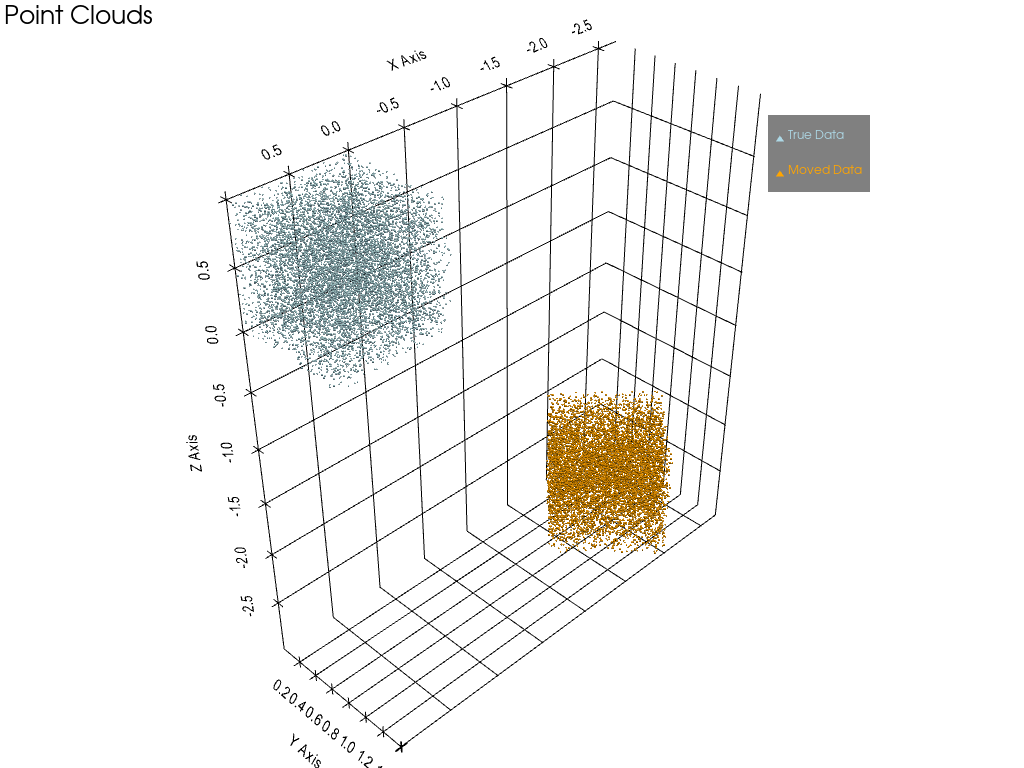

In [17]:
'''Assign data to point clouds P and Q''' 
angle = [0, 0, math.pi/4]
shift = np.array([[-2], [0], [-3]])
Q, P = generateData(10000, angle, shift)

bigPlot(P, Q, 2, 2)

Iteration: 100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


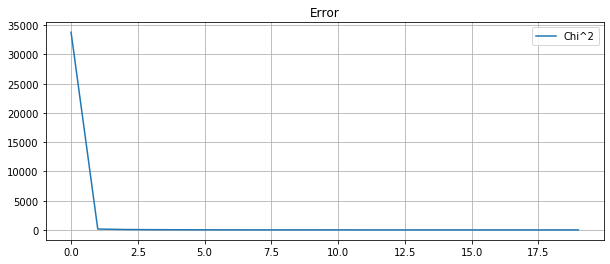

NameError: name 'Pvalues' is not defined

In [18]:
%%time
normals, normals_to_draw = computeNormals(Q)
P_values, chi_values, corresp_values = ICP(P, Q, normals)
plotValues(chi_values, label="Chi^2")
bigPlot(Pvalues[-1], Q, 5, 5)

### Ten Lakh

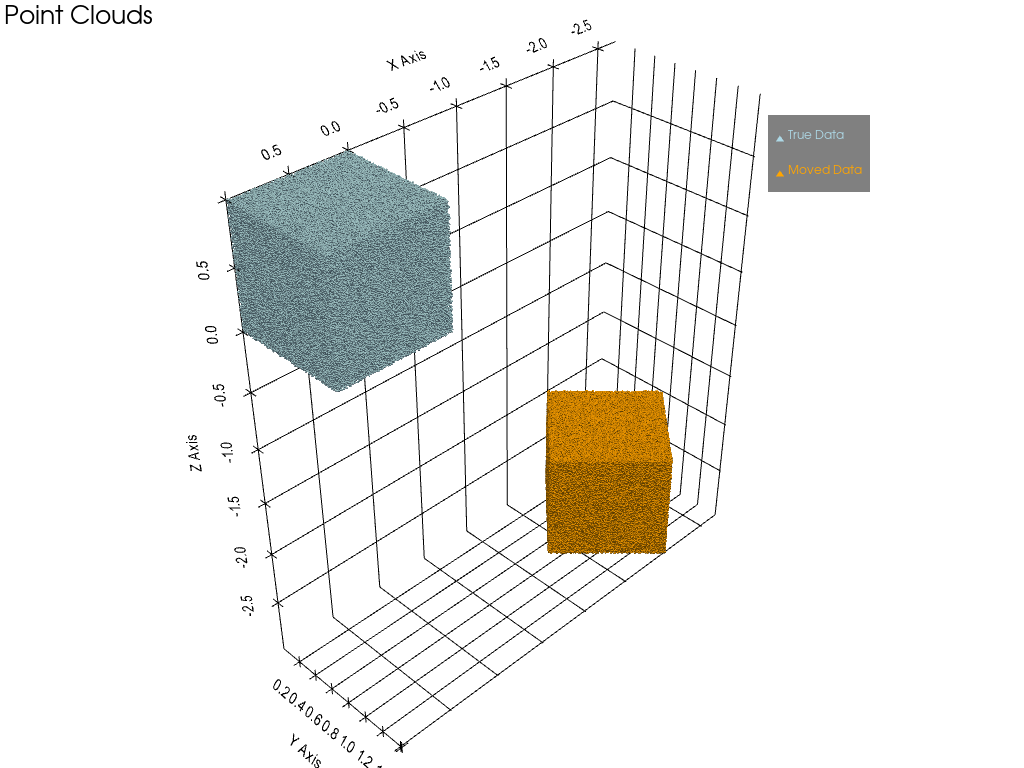

In [19]:
'''Assign data to point clouds P and Q''' 
angle = [0, 0, math.pi/4]
shift = np.array([[-2], [0], [-3]])
Q, P = generateData(1000000, angle, shift)

bigPlot(P, Q, 2, 2)

In [ ]:
%%time
normals, normals_to_draw = computeNormals(Q)
P_values, chi_values, corresp_values = ICP(P, Q, normals)
plotValues(chi_values, label="Chi^2")
bigPlot(Pvalues[-1], Q, 5, 5)

### Redwood Dataset

In [23]:
import open3d as o3d

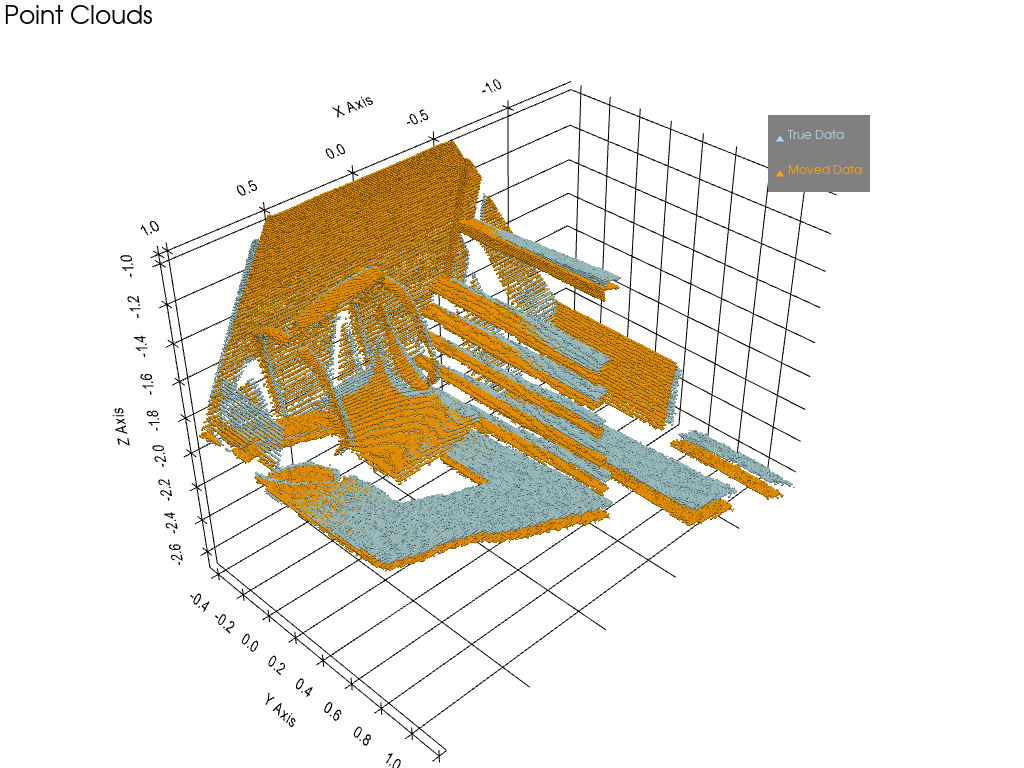

In [24]:
rawColor = o3d.io.read_image("Dataset/00000.jpg")
rawDepth = o3d.io.read_image("Dataset/00000.png")

rgbdImage = o3d.geometry.RGBDImage.create_from_color_and_depth(rawColor, rawDepth)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
         rgbdImage,
         o3d.camera.PinholeCameraIntrinsic(
         o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))

pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

P = np.array(np.asarray(pcd.points)).T

rawColor = o3d.io.read_image("Dataset/00004.jpg")
rawDepth = o3d.io.read_image("Dataset/00004.png")

rgbdImage = o3d.geometry.RGBDImage.create_from_color_and_depth(rawColor, rawDepth)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbdImage,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

Q = np.array(np.asarray(pcd.points)).T
minPoints =  min(P.shape[1], Q.shape[1])
P, Q = P[:, :minPoints], Q[:, :minPoints]

bigPlot(P, Q, 2, 2)

In [ ]:
%%time
normals, normals_to_draw = computeNormals(Q)
P_values, chi_values, corresp_values = ICP(P, Q, normals)
plotValues(chi_values, label="Chi^2")
bigPlot(Pvalues[-1], Q, 5, 5)

### My Room 

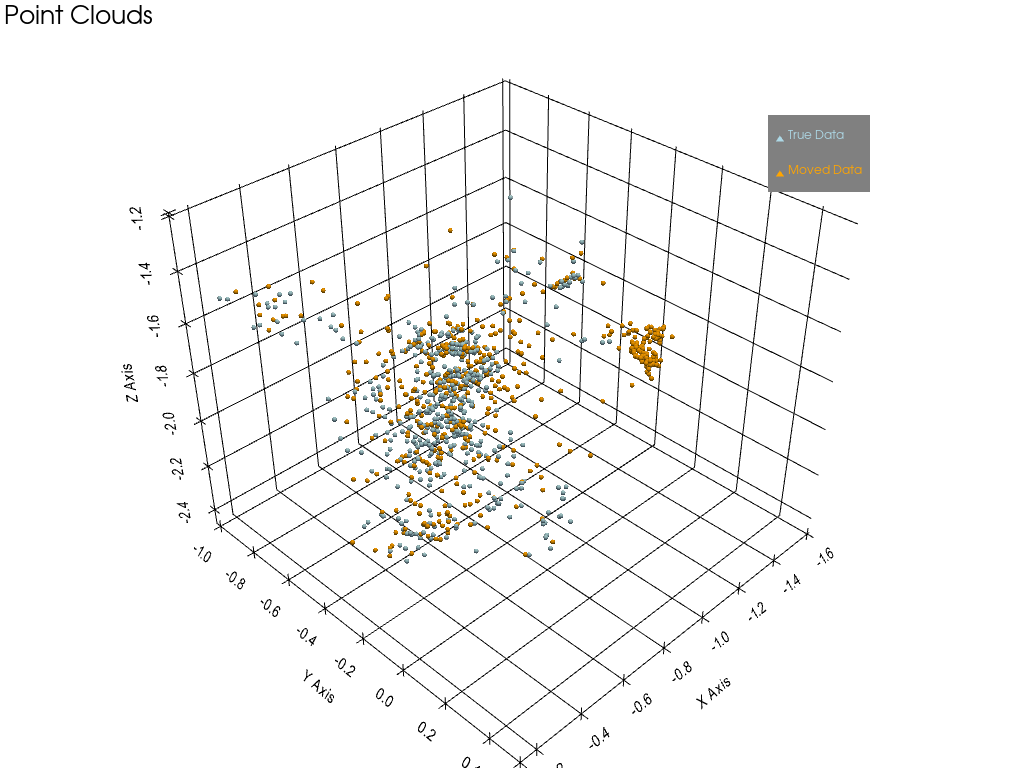

In [28]:
sourceload = o3d.io.read_point_cloud("ply/roomOne.ply")
Q = np.asarray(sourceload.points).T

destinationload = o3d.io.read_point_cloud("ply/roomTwo.ply")
P = np.asarray(destinationload.points).T

bigPlot(P, Q, 5, 5)



Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:  10%|█         | 2/20 [00:00<00:01, 11.46it/s]

Iteration:  15%|█▌        | 3/20 [00:00<00:01, 10.78it/s]

Iteration:  25%|██▌       | 5/20 [00:00<00:01, 11.14it/s]

Iteration:  35%|███▌      | 7/20 [00:00<00:01, 11.46it/s]

Iteration:  45%|████▌     | 9/20 [00:00<00:00, 11.67it/s]

Iteration:  55%|█████▌    | 11/20 [00:00<00:00, 11.90it/s]

Iteration:  65%|██████▌   | 13/20 [00:01<00:00, 11.85it/s]

Iteration:  75%|███████▌  | 15/20 [00:01<00:00, 11.94it/s]

Iteration:  85%|████████▌ | 17/20 [00:01<00:00, 12.16it/s]

Iteration: 100%|██████████| 20/20 [00:01<00:00, 12.01it/s]


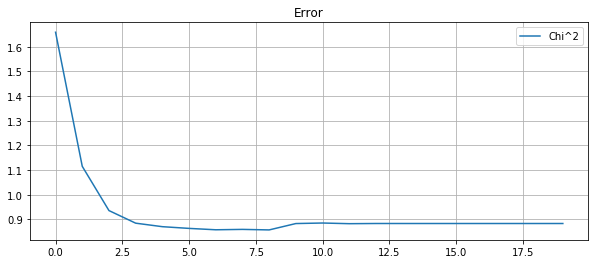

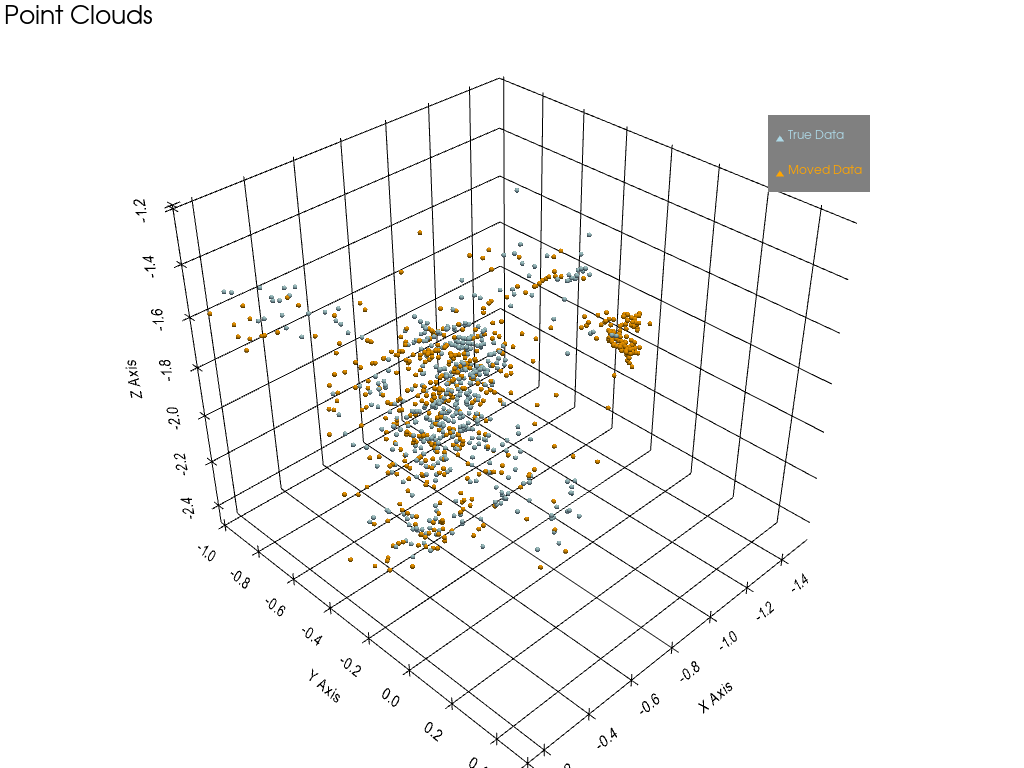

CPU times: user 2.04 s, sys: 28.1 ms, total: 2.07 s
Wall time: 2.04 s


In [30]:
%%time
normals, normals_to_draw = computeNormals(Q)
Pvalues, chivalues, correspvalues = ICP(P, Q, normals)
plotValues(chivalues, label="Chi^2")
bigPlot(Pvalues[-1], Q, 5, 5)